# Szeregi czasowe

W tym zadaniu zostanie wykonana predykcja szeregu czasowego. Wykorzystanym zbiorem danych jest [Airline Passengers](https://www.kaggle.com/chirag19/air-passengers).

In [135]:
import os, sys, inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from settings import DATA_PATH
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Wczytanie danych
Załadowanie danych z pliku CSV i podział ich na t - kroki czasowe (indeksy) oraz x - wartości.

In [91]:
def load_data():
    file_path = os.path.join(DATA_PATH, "air-passengers", "AirPassengers.csv")
    df_air = pd.read_csv(file_path)
    t = df_air.index.values
    x = df_air["#Passengers"].values
    return t, x

In [92]:
t, x = load_data()

### Podział na zbiór uczący i walidujący
Zgodnie z zaleceniem przewidywane będzie ostatnie 12 próbek.

In [93]:
def split_train_test(t, x, test_size=12):
    t_train = t[:-test_size]
    x_train = x[:-test_size]
    t_test = t[-test_size:]
    x_test = x[-test_size:]
    return t_train, x_train, t_test, x_test

In [94]:
t_train, x_train, t_test, x_test = split_train_test(t, x)

Sprawdzenie czy operacja podziału na zbiory: uczący i testujący, została wykonana poprawnie.

In [95]:
print(len(t_train) + len(t_test), len(t))

144 144


# Wykres szeregu czasowego

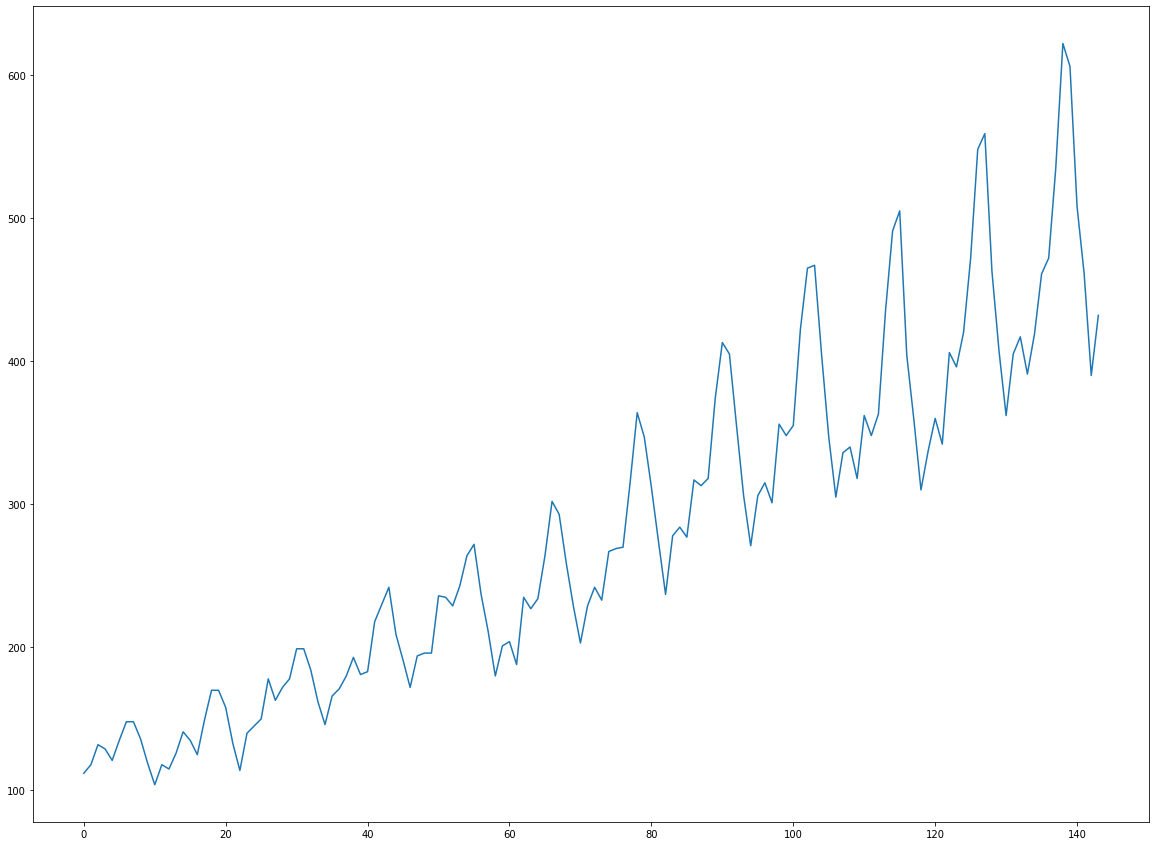

In [137]:
fig = plt.figure(figsize=(20, 15))
sns.lineplot(x=t, y=x)

# AutoRegressive Model
Model autoregresyjny. Zaimplementowany został w nieco trudniejszym wariancie, to jest takim, w którym predykcja próbki w kroku t + 1 odbywa się na podstawie wartości predykowanej z kroku t, a nie wartości prawdziwej. Po predykcji wartości w kroku t, nie jest ona zastępowana przez wartość prawdziwą na potrzeby predykcji wartości t + 1.

In [123]:
class AutoRegressiveModel:
    def __init__(self, window):
        self.window = window
        self.model = None
        self.coef = None
        self.history = None
        
    def fit(self, x_train):
        self.model = AutoReg(x_train, lags=self.window)
        model_fit = self.model.fit()
        self.coef = model_fit.params
        
        # create history of time series for prediction
        history = x_train[len(x_train) - self.window:]
        self.history = [history[i] for i in range(len(history))]
        
    def predict(self, n):
        history = self.history.copy()
        predictions = list()
        for t in range(n):
            length = len(history)
            lag = [history[i] for i in range(length - self.window, length)]
            yhat = self.coef[0]
            for d in range(self.window):
                yhat += self.coef[d + 1] * lag[self.window - d - 1]
            predictions.append(yhat)
            history.append(yhat)
        return predictions
    
    def predict_start_with(self, n, start_with):
        if len(start_with) < self.window:
            raise ValueError("Length of starts_with has to be greater or equal to self.window.")
        history = list(start_with.copy())
        predictions = list()
        for t in range(n):
            length = len(history)
            lag = [history[i] for i in range(length - self.window, length)]
            yhat = self.coef[0]
            for d in range(self.window):
                yhat += self.coef[d + 1] * lag[self.window - d - 1]
            predictions.append(yhat)
            history.append(yhat)
        return predictions

## Badania nad doborem najlepszej wartości hiperparametru window

In [124]:
def experiments():
    df_results = pd.DataFrame(columns=["model", "window_size", "mae", "rmse"])
    
    for window_size in range(1, 30):
        model = AutoRegressiveModel(window = window_size)
        model.fit(x_train)
        predictions = model.predict(len(x_test))
        mae = sqrt(mean_absolute_error(x_test, predictions))
        rmse = sqrt(mean_squared_error(x_test, predictions))
        
        df_results = df_results.append([{"model": "AR", "window_size": window_size, 
                                         "mae": mae, "rmse": rmse}], ignore_index=True)
    
    return df_results

In [125]:
df_results = experiments()
df_results

,model,window_size,mae,rmse
0,AR,1,9.751612,122.102970
1,AR,2,10.287071,133.059161
2,AR,3,9.574888,118.419781
3,AR,4,8.941213,105.760241
4,AR,5,8.319677,90.477154
5,AR,6,8.412746,91.374115
6,AR,7,8.066523,84.426305
7,AR,8,7.810299,78.851925
8,AR,9,6.594770,49.854632
9,AR,10,6.170283,42.412083


## Najlepszy model - eksperymenty
Według miary MAE oraz miary RMSE. Jak widać, oba modele mają podobne wartości obu miar.

In [126]:
df_results[df_results["mae"] == df_results["mae"].min()]

,model,window_size,mae,rmse
24,AR,25,3.092629,14.357007


In [127]:
df_results[df_results["rmse"] == df_results["rmse"].min()]

,model,window_size,mae,rmse
21,AR,22,3.201825,13.883705


### Zależność metryk od rozmiaru okna
Może pomóc wybrać najlepszy model.

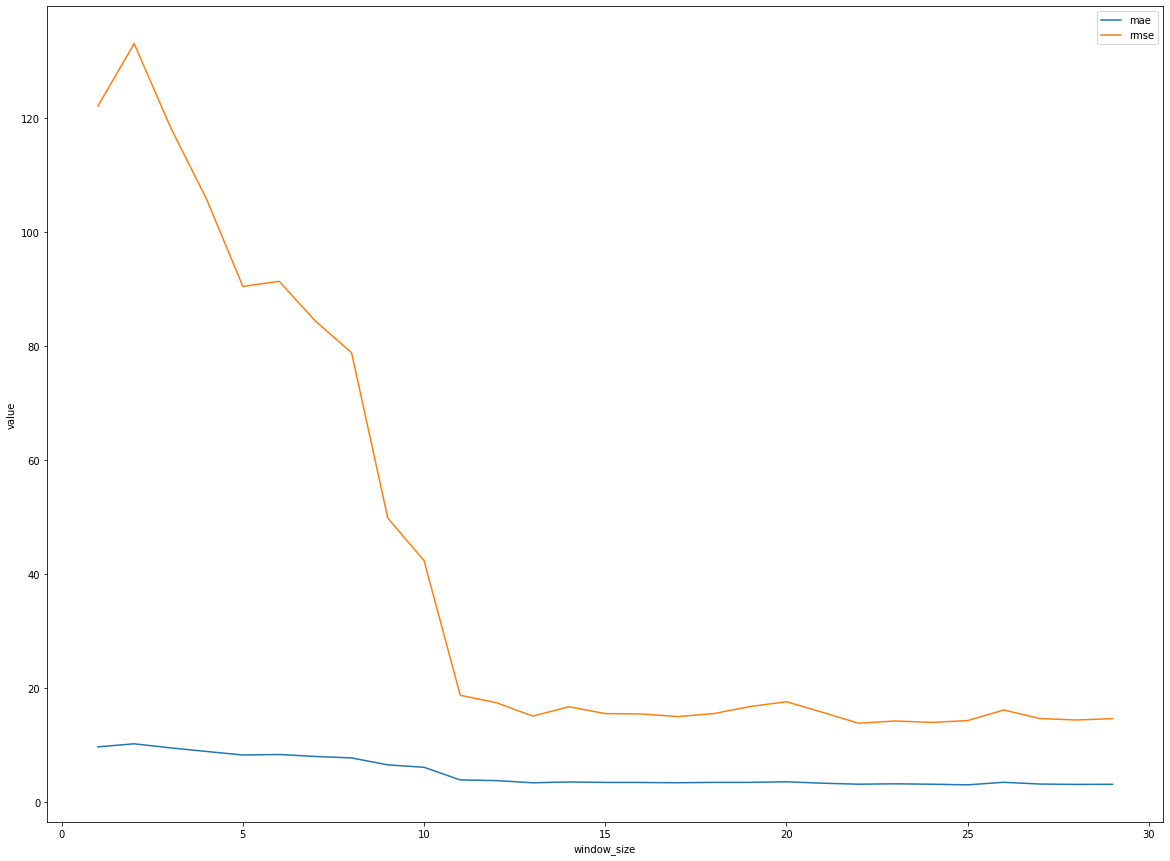

In [128]:
fig = plt.figure(figsize=(20, 15))
ax = sns.lineplot(x=df_results.window_size, y=df_results.mae, label="mae")
ax = sns.lineplot(x=df_results.window_size, y=df_results.rmse, label="rmse")
ax.set_ylabel("value")
ax.legend()

## Najlepszy model - wykres
Ostatecznie zdecydowano się wybrać model 21. o minimalnej wartości metryki RMSE. Posiada on hiperparametr window_size o wartości równej 22.

In [129]:
model = AutoRegressiveModel(window = 22)
model.fit(x_train)
predictions = model.predict(len(x_test))
mae = sqrt(mean_absolute_error(x_test, predictions))
rmse = sqrt(mean_squared_error(x_test, predictions))
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

Test MAE: 3.202
Test RMSE: 13.884


Wykres całej serii czasowej. Niebieskim kolorem oznaczono przebieg rzeczywisty, czerwonym predykowane ostatnie 12 próbek.

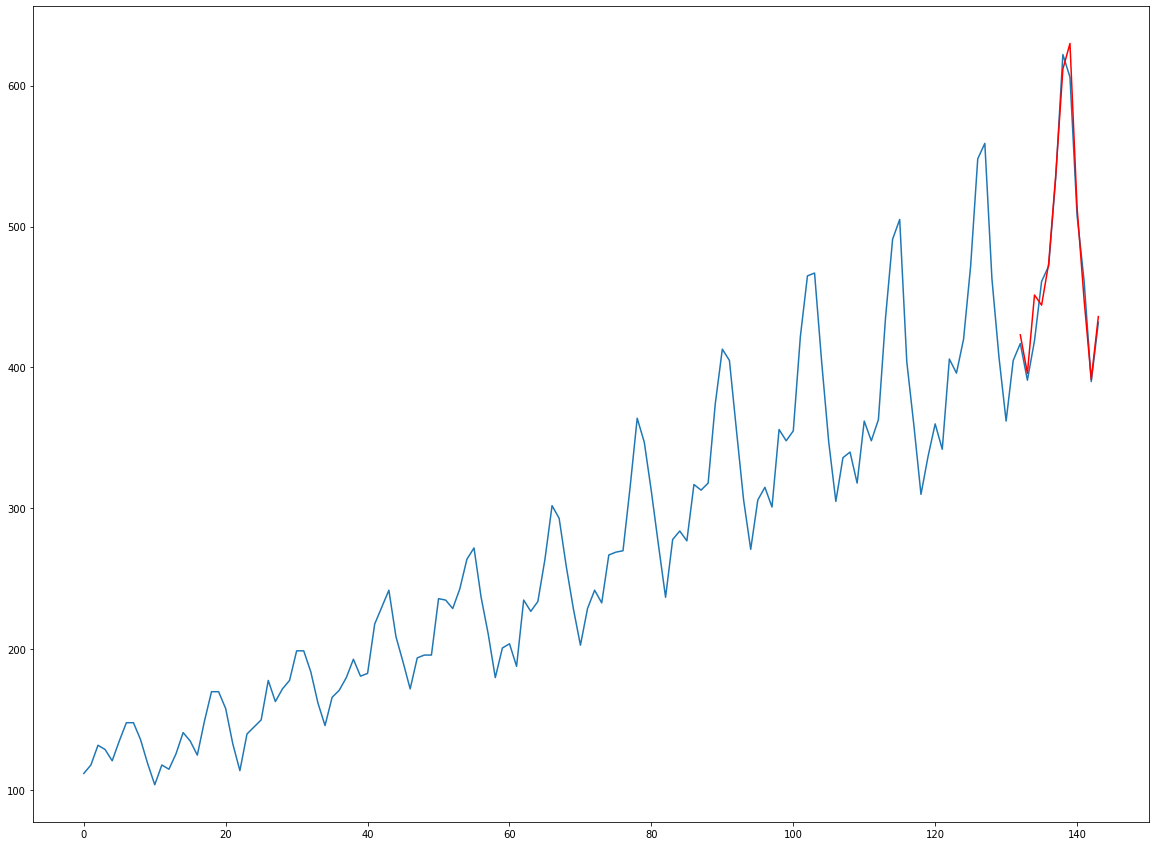

In [130]:
fig = plt.figure(figsize=(20, 15))
sns.lineplot(x=t, y=x)
sns.lineplot(x=t_test, y=predictions, color='red')

Wykres tylko ostatnich 12 próbek. Niebieskim kolorem oznaczono przebieg rzeczywisty, czerwonym predykcję.

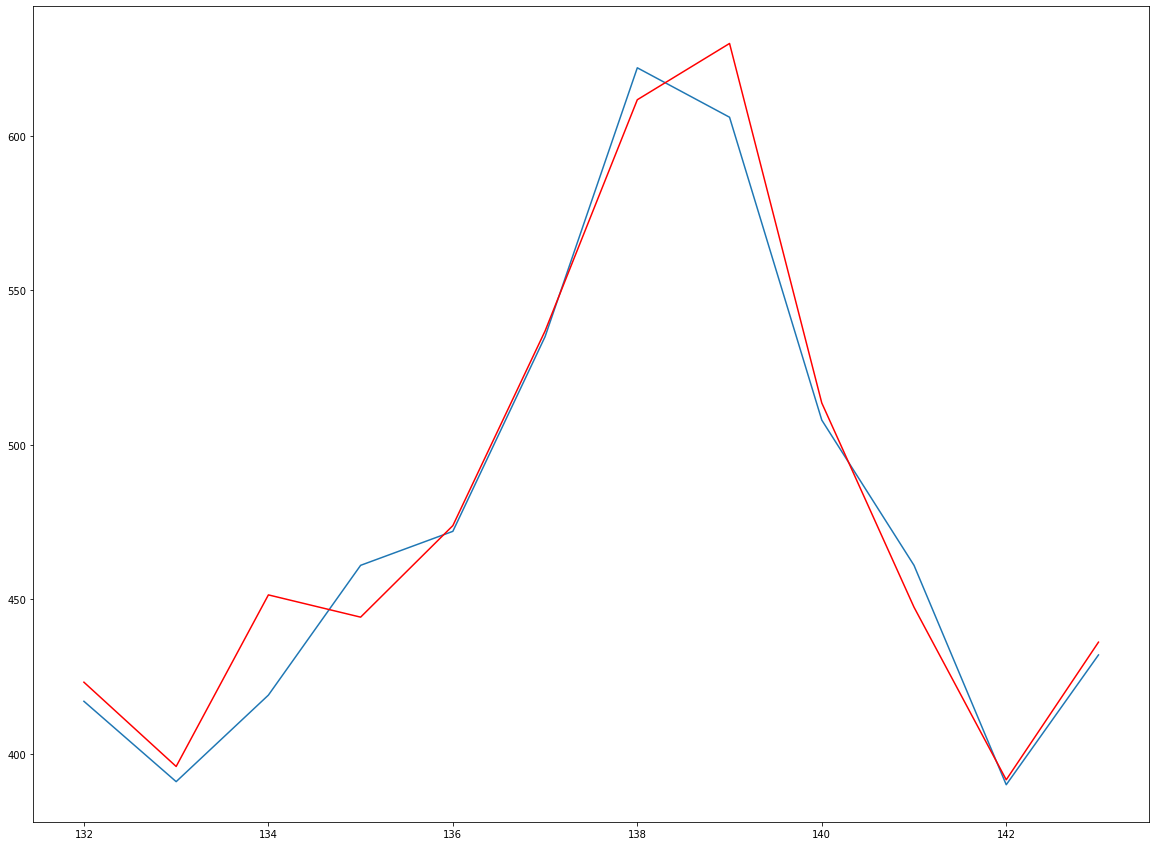

In [131]:
fig = plt.figure(figsize=(20, 15))
sns.lineplot(x=t_test, y=x_test)
sns.lineplot(x=t_test, y=predictions, color='red')

Widać, że model całkiem dobrze dopasował się do rzeczywistych danych.

# Autokorelogram i autokorelogram częściowy (ACF i PACF)

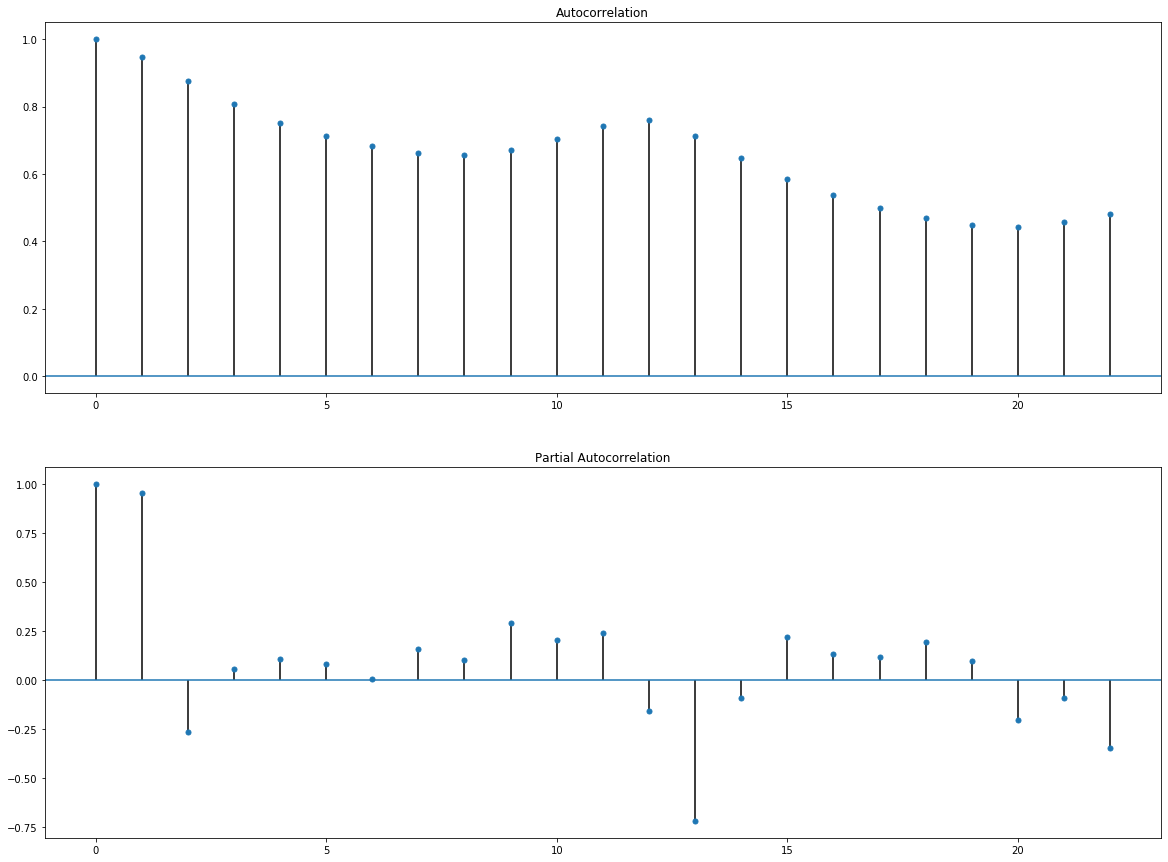

In [132]:
fig = plt.figure(figsize=(20, 15))
plt.subplot(211)
plot_acf(x, ax=plt.gca(), alpha=None)
plt.subplot(212)
plot_pacf(x, ax=plt.gca(), alpha=None)
plt.show()

W autokorelogramie (ACF) widać "górkę" w okolicach LAG 12. Oznacza ona, że następuje wzrost korelacji co 12 próbek, czyli występuje sezonowość o okresie roku.
W autokorelogramie częściowym (PACF) widać wysoką korelację tylko w okolicach próbek LAG 0 i 1 oraz korelację ujemną dla LAG 13.

### Autokorelogram na podstawie stworzonego modelu

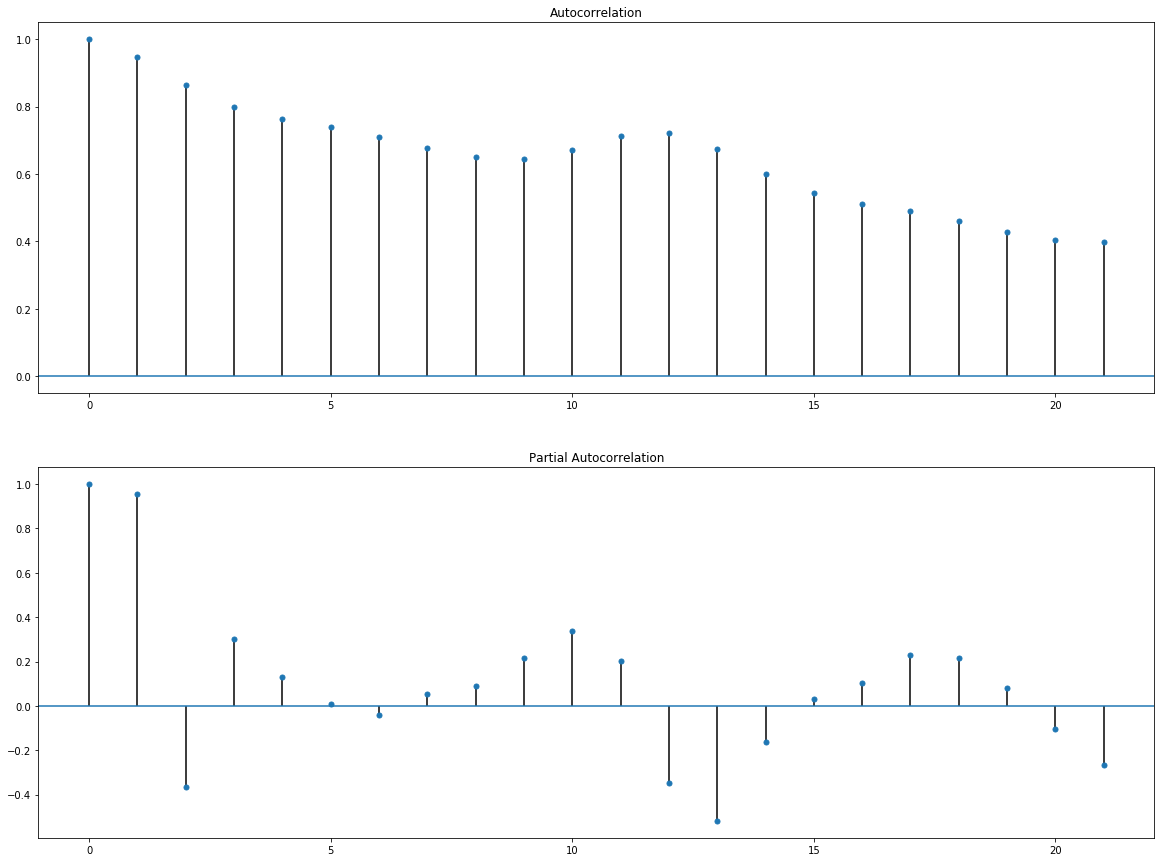

In [136]:
start_with = x[:model.window]
n = len(x) - model.window
model_x = model.predict_start_with(n, start_with)
model_x = np.asarray(model_x)
fig = plt.figure(figsize=(20, 15))
plt.subplot(211)
plot_acf(model_x, ax=plt.gca(), alpha=None)
plt.subplot(212)
plot_pacf(model_x, ax=plt.gca(), alpha=None)
plt.show()

Autokorelogram stworozonego modelu jest bardzo podobny do korelogramu oryginalnego ciągu. To oznacza, że model bardzo dobrze oddaje charakterystykę serii czasowej. Częściowy autokorelogram jest nieco mniej podobny. Może to oznaczać, że rezydua nie są zamodelowane aż tak dobrze jak trend i sezonowość.

# Podsuomowanie

Wykorzystując zbiór danych [Airline Passengers](https://www.kaggle.com/chirag19/air-passengers) wykonano predykcję ostatnich dwunastu wartości szeregu czasowego.

Prace rozpoczęto wykonaniem wykresu, pozwalającym zapoznać się z charakterme danych. Stworzono model autoregresyjny (AR) oraz wykonano strojenie hiperparametru tego modelu, którym jest liczba opóżnień (rozmiar) wykorzystana w modelowaniu. Na podstawie przeprowadzonych badań wybrano najlepszą wartość hiperparametru. Następnie zbadana autokorelację (ACF i PACF) szeregu czasowego oraz szeregu wygenerowanego za pomocą wyuczonego modelu.

Kierując się miarą Root Mean Square Error, wybrano model o liczbie 22 opóżnień, jako najlepiej modelujący szereg czasowy. Wybrano model AR, ponieważ wstępna analiza szeregu czasowego pozwoliła przypuszczać, że wyraźna sezonowość i trend zostaną dobrze zamodelowane przez ten model.


## Wnioski

- Model autoregresyjny dobrze poradził sobie z modelowanie zadanego szeregu czasowego.

- Sezonowość szeregu czasowego wynosząca 12 próbek (miesięcy), powoduje że dla k od 1 do 12 następuje gwałtowny spadek wartości błędu, a następnie stablizuje się on. K oznacza liczbę opóżnień w modelu AR(k) oraz przesunięcie w operatorze LAG-k.

- Badając autokorelogram szeregu czasowego oraz szeregu wygenerowanego za pomocą modelu AR, można zauważyć, że bardzo dobrze modeluje on sezonowość szeregu. Nieco gorzej wypada modelowanie rezyduów. Z tym zadaniem pewnie lepiej poradziłby sobie model MA.
